#  XPCS   Two-time SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [39]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
#hdr = db[{{ uid }}]

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Lazy Eiger Handler (later will goto databroker)

In [4]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [5]:
#%matplotlib notebook
%matplotlib inline

### Get the events from the uid

In [6]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [7]:
uid = 'ee6975a1-9161'
hdr = db[uid]

In [10]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5


In [11]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/11/23/'

In [12]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [13]:
imgs.md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'framerate': 200.00000447034847,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [14]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(0.0049999999, 0.0049899998)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [15]:
#mask = np.load(uid+"_mask.npy")
mask = np.load( path +  str(uid)+"_mask.npy")

## Plot the mask

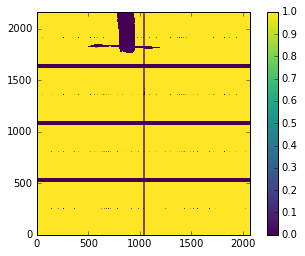

In [16]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

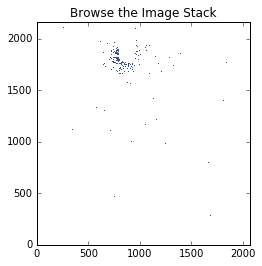

<function __main__.view_image>

In [17]:
from ipywidgets import interact

def view_image(i):
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e10 ) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, Nimg-1))

### Get the Averaged Image Data

In [18]:
avg_img = np.average(imgs[::50], axis=0)*mask

## Plot the averged image with the mask

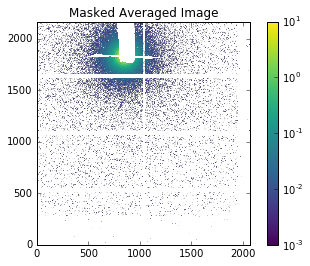

In [19]:
img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [20]:
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Get the approximate center and see the statistic to make sure 

In [21]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(852.0, 1830.0)

In [22]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center = [2167 - 336, 849]
#center = [center[1], center[0]]

center

[1831, 849]

## Create label array (Q rings)

In [23]:
inner_radius = 58 # radius of the first ring
width = 2       # width of each ring
spacing =  (166 - 58)/9 - 2    # spacing between rings
num_rings = 6   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  58.,   60.],
       [  70.,   72.],
       [  82.,   84.],
       [  94.,   96.],
       [ 106.,  108.],
       [ 118.,  120.]])

In [24]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00403645,  0.00485743,  0.0056784 ,  0.00649937,  0.00732034,
        0.00814131])

In [25]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask



# check center

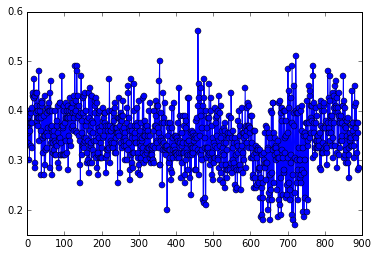

In [26]:
pixel = roi.roi_pixel_values(avg_img*mask, ring_mask, [5] )
fig, ax = plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )
plt.show()

## To mask the each image

In [27]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [28]:
masker = Masker(imgs, mask)

In [29]:
import xray_vision.mpl_plotting as mpl_plot
def show_label_array_on_image(ax, image, label_array, cmap=None,norm=None,
                              imshow_cmap='gray', **kwargs):  
    """
    This will plot the required ROI's(labeled array) on the image
    Additional kwargs are passed through to `ax.imshow`.
    If `vmin` is in kwargs, it is clipped to minimum of 0.5.
    Parameters
    ----------
    ax : Axes
        The `Axes` object to add the artist too
    image : array
        The image array
    label_array : array
        Expected to be an unsigned integer array.  0 is background,
        positive integers label region of interest
    cmap : str or colormap, optional
        Color map to use for plotting the label_array, defaults to 'None'
    imshow_cmap : str or colormap, optional
        Color map to use for plotting the image, defaults to 'gray'
    norm : str, optional
        Normalize scale data, defaults to 'Lognorm()'
    Returns
    -------
    im : AxesImage
        The artist added to the axes
    im_label : AxesImage
        The artist added to the axes
    """
    ax.set_aspect('equal')
    im = ax.imshow(image, cmap=imshow_cmap, interpolation='none', norm=LogNorm(norm), 
                   **kwargs)
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm,
                                **kwargs)  
    
    
    return im, im_label 

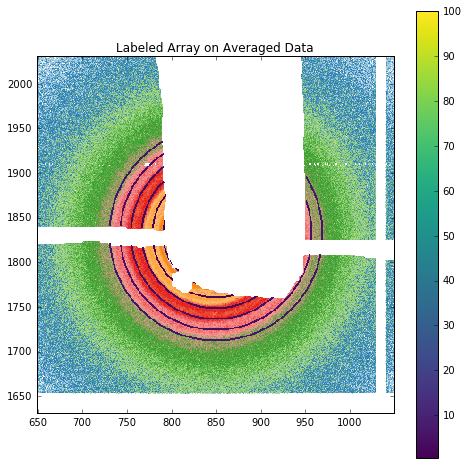

In [30]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im, im_label = show_label_array_on_image(axes, avg_img, ring_mask, cmap='viridis',
                            imshow_cmap='Paired', vmin=0.01, vmax=100. , origin="lower")
rwidth = 200 
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim([x1, x2])
axes.set_ylim([y1, y2])
fig.colorbar(im_label)
plt.show()

In [31]:
ring_mask = np.array(ring_mask, dtype=int)

## Two time correaltion

In [32]:
from __future__ import absolute_import, division, print_function
import logging
import time

logger = logging.getLogger(__name__)

def two_time_corr(labels, images, num_frames, num_bufs, num_levels=1):
    """
    This function computes two-time correlations.
    Original code : @author: Yugang Zhang

    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.

    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr

    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : array
        dimensions are: (rr, cc), iterable of 2D arrays
    num_frames : int
        number of images to use
        default is number of images
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
        default is number of images
    num_levels : int, optional
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames
        default is one

    Returns
    -------
    two_time : array
        matrix of two time correlation
        shape (number of images, number of images, number of labels(ROI))

    Notes
    -----
    The two-time correlation function is defined as

    :math ::
        C(q, t_1, t_2) = \frac{<I(q, t_1)I(q, t_2)>_pix }{<I(q, t_1)>_pix <I(q, t_2)>_pix}

    Here, the ensemble averages are performed over many pixels of detector,
    all having the same q value. The average time or age is equal to (t1+t2)/2,
    measured by the distance along the t1 = t2 diagonal.
    The time difference t = |t1 - t2|, with is distance from the t1 = t2
    diagonal in the perpendicular direction.
    In the equilibrium system, the two-time correlation functions depend only
    on the time difference t, and hence the two-time correlation contour lines
    are parallel.

    References
    ----------

    .. [1] A. Fluerasu, A. Moussaid, A. Mandsen and A. Schofield,
        "Slow dynamics and aging in collodial gels studied by x-ray photon
         correlation spectroscopy," Phys. Rev. E., vol 76, p 010401(1-4), 2007.
    """

    label_array, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs,
                                                                     labels,
                                                                     images)

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # two time correlation results (array)
    two_time = np.zeros((num_frames, num_frames, num_rois), dtype=np.float64)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    start_time = time.time()  # used to log the computation time (optionally)
    #  for two time correlation

    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    for n, img in enumerate(images):
        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        count_level[0] = 1 + count_level[0]
        # current image number
        current_img_time = n + 1

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time and img_per_level in place!
        _two_time_process(buf, two_time, label_array, num_bufs, num_pixels,
                          img_per_level, lag_steps, current_img_time, level=0,
                          buf_no=cur[0] - 1)

        # time frame for each level
        time_ind[0].append(current_img_time)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        # Compute the correlations for all higher levels.
        level = 1
        while processing:
            if not track_level[level]:
                track_level[level] = 1
                processing = False
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs
                count_level[level] = 1 + count_level[level]

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                t1_idx = (count_level[level] - 1) * 2

                current_img_time = ((time_ind[level - 1])[t1_idx]
                                    + (time_ind[level - 1])[t1_idx + 1])/2.

                # time frame for each level
                time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(buf, two_time, label_array, num_bufs,
                                  num_pixels, img_per_level, lag_steps,
                                  current_img_time, level=level,
                                  buf_no=cur[level]-1)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

    for q in range(np.max(labels)):
        x0 = two_time[:, :, q]
        two_time[:, :, q] = (np.tril(x0) + np.tril(x0).T
                               - np.diag(np.diag(x0)))
    # Two time correlation processing time
    logger.info("Two Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (time.time() - start_time)))

    return two_time


def _two_time_process(buf, two_time, label_array, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, level,
                      buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation
    two_time: array
        two time correlation matrix
    label_array: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    num_bufs: int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]
    img_per_level: array
        to track how many images processed in each level
    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels
    current_img_time : int
        the current image number
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_array)

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                two_time[int(tind1+i),
                           int(tind2+i)] = (tmp_binned/(pi_binned *
                                                        fi_binned))*num_pixels
        else:
            two_time[tind1, tind2] = tmp_binned/(pi_binned *
                                                   fi_binned)*num_pixels


def _help_process(level, num_bufs, buf_no, i, buf, label_array):
    """
    This is a helper function for both one time and two time correlation
    process functions.

    Parameters
    ----------
    level : int
        the current multi-tau level
    num_bufs : int
        number of buffers(channels)
    buf_no : int
        the current buffer number
    i : int

    buf : array
        image data array to use for two time correlation
    label_array: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments

    Returns
    -------
    t_index : float
        time
    tmp_binned : array
        matrix of correlation function without normalizations
    pi_binned : array
        matrix of past intensity normalizations
    fi_binned : array
        matrix of future intensity normalizations
    """
    t_index = level*num_bufs/2 + i

    delay_no = (buf_no - i) % num_bufs

    past_img = buf[level, delay_no]
    future_img = buf[level, buf_no]

    #  get the matrix of correlation function without normalizations
    tmp_binned = (np.bincount(label_array,
                              weights=past_img*future_img)[1:])
    # get the matrix of past intensity normalizations
    pi_binned = (np.bincount(label_array,
                             weights=past_img)[1:])

    # get the matrix of future intensity normalizations
    fi_binned = (np.bincount(label_array,
                             weights=future_img)[1:])
    return t_index, tmp_binned, pi_binned, fi_binned


def _validate_inputs(num_bufs, labels, images):
    """
    This is a helper function to validate inputs for both one time and
    two time correlation

    Parameters
    ----------
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
      labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : iterable of 2D arrays
        dimensions are: (rr, cc)

    Returns
    -------
    label_array : array
        labels of the required region of interests(ROI's)
    indices : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : array
        number of ROI's
    num_pixels : array
        number of pixels in each ROI's
    """
    if num_bufs % 2 != 0:
        raise ValueError("number of channels(number of buffers) in "
                         "multiple-taus (must be even)")

    if hasattr(images, 'frame_shape'):
        # Give a user-friendly error if we can detect the shape from pims.
        if labels.shape != images.frame_shape:
            raise ValueError("Shape of the images should be equal to"
                             " shape of the labels array")

    # get the pixels in each label
    label_array, indices = roi.extract_label_indices(labels)

    num_rois = np.max(label_array)

    # number of pixels per ROI
    num_pixels = np.bincount(label_array, minlength=(num_rois+1))
    num_pixels = num_pixels[1:]

    if np.any(num_pixels == 0):
        raise ValueError("Number of pixels of the required roi's"
                         " cannot be zero, "
                         "num_pixels = {0}".format(num_pixels))

    return label_array, indices, num_rois, num_pixels


def one_time_from_two_time(two_time_corr):
    """
    Parameters
    ----------
    two_time_corr : array
        matrix of two time correlation
        shape (number of images, number of images, number of labels(ROI))

    Returns
    -------
    one_time_corr : array
        matrix of one time correlation
        shape (number of images, number of labels(ROI))

    """
    one_time_corr = np.zeros((two_time_corr.shape[0], two_time_corr.shape[2]))
    for i in range(two_time_corr.shape[2]):
        for j in range(two_time_corr.shape[0]):
            one_time_corr[j, i] = np.trace(two_time_corr[:, :, i],
                                           offset=j)/two_time_corr.shape[0]
    return one_time_corr



In [33]:
two1 = two_time_corr(ring_mask, imgs[0:500], num_frames=500, num_bufs=12, num_levels=4)

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:225: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


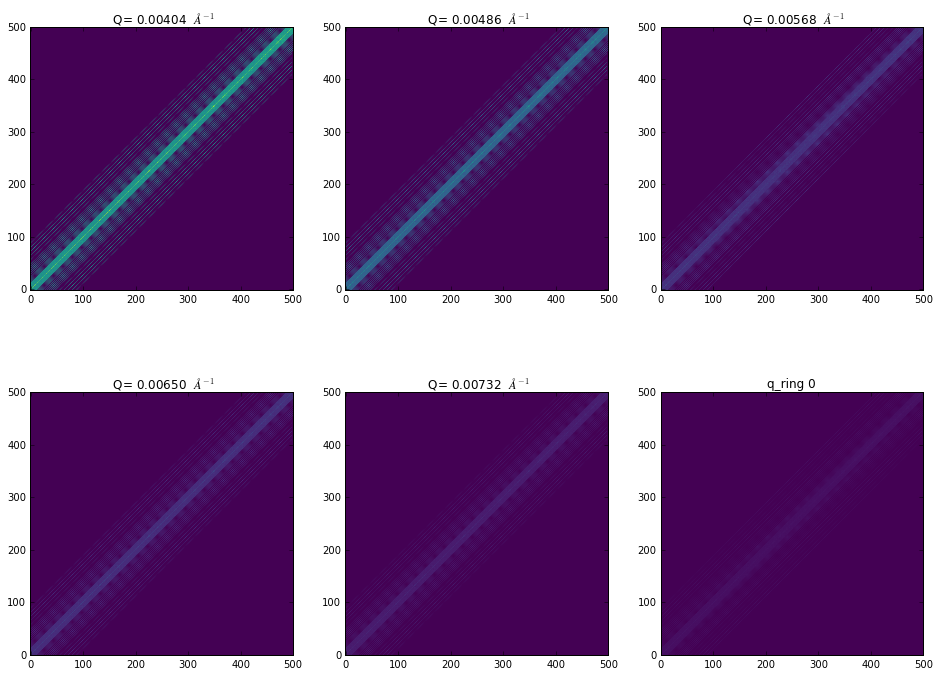

In [34]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    ax.imshow(two1[:, :, 0], cmap='viridis', vmin=0, vmax=np.max(two1[:, :, i]),
              origin="lower")
ax.set_title("q_ring "+str(0))
plt.show()
fig.tight_layout()  

##  Two time correlation for all the images, (Brute force not multi tau), 
Here num_levels = 1, num_bufs = all the images

In [37]:
#   here using 500 images
two_time_all = two_time_corr(ring_mask, imgs[0:500],
                             num_frames=500, num_bufs=500,
                             num_levels=1)

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:225: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:235: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


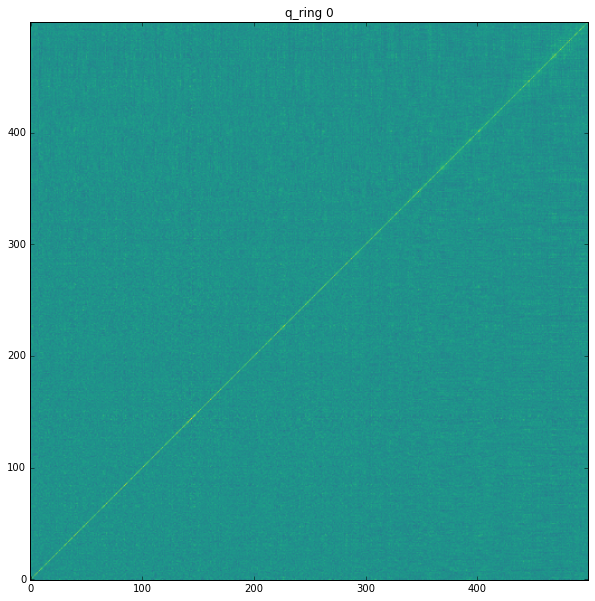

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(two_time_all[:, :, 0], cmap='viridis', vmin=0,
          vmax=np.max(two_time_all[:, :, 0]), origin="lower")
ax.set_title("q_ring "+str(0))
plt.show()

### Plot for all ROI's

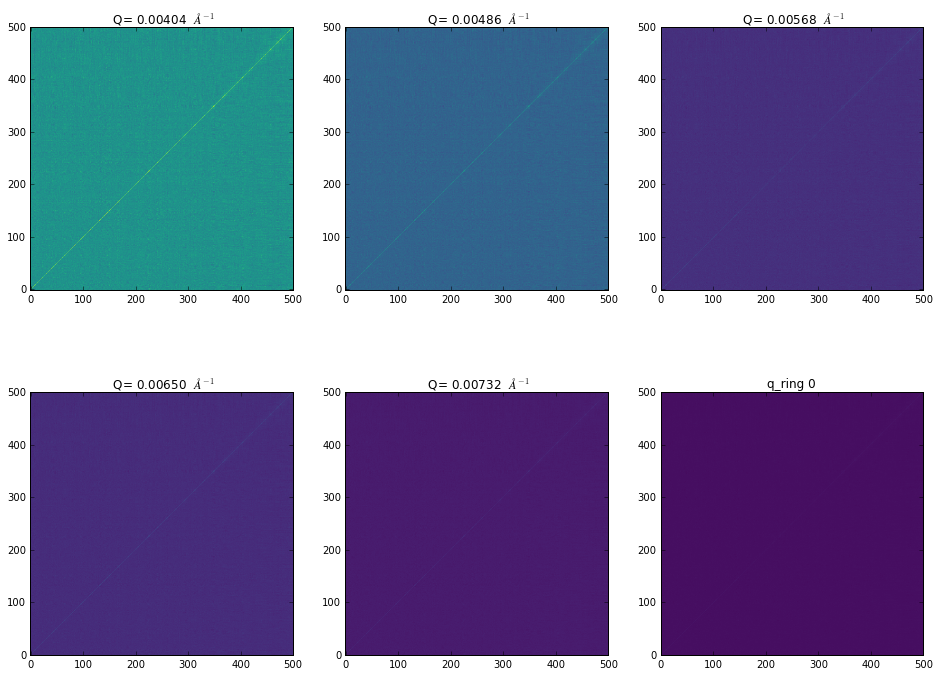

In [40]:
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    ax.imshow(two_time_all[:, :, 0], cmap='viridis', vmin=0, vmax=np.max(two_time_all[:, :, i]), origin="lower")
ax.set_title("q_ring "+str(0))
plt.show()
fig.tight_layout()  

In [47]:
two_time_10k = two_time_corr(ring_mask, imgs,
                             num_frames=len(imgs), num_bufs=len(imgs),
                             num_levels=1)

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:225: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:235: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


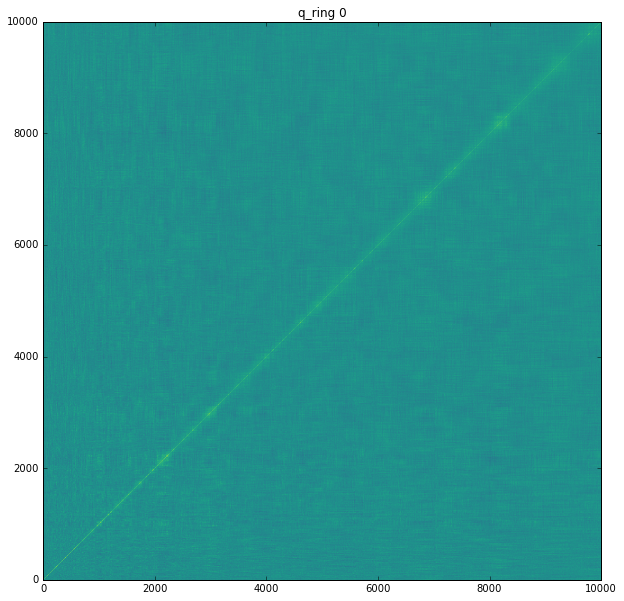

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(two_time_10k[:, :, 0], cmap='viridis', vmin=0,
          vmax=np.max(two_time_10k[:, :, 0]), origin="lower")
ax.set_title("q_ring "+str(0))
plt.show()

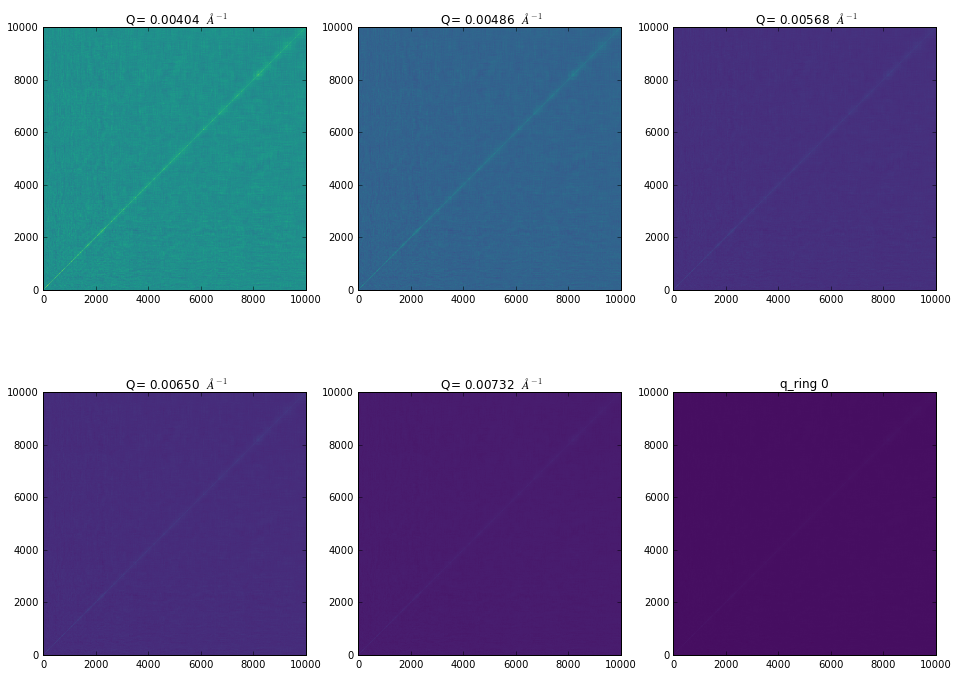

In [49]:
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    ax.imshow(two_time_10k[:, :, 0], cmap='viridis', vmin=0, vmax=np.max(two_time_10k[:, :, i]), origin="lower")
ax.set_title("q_ring "+str(0))
plt.show()
fig.tight_layout()  

## Get the one time correaltion data from two time corraltion data

In [58]:
one_time1 = one_time_from_two_time(two_time_10k)

In [59]:
one_time1.shape

(10000, 6)

## One time Correlation  ( Multi tau)

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [55]:
num_lev = 20  # number of levels
num_buf = 32  # number of buffers

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, imgs)

### Plot the one time correlation functions

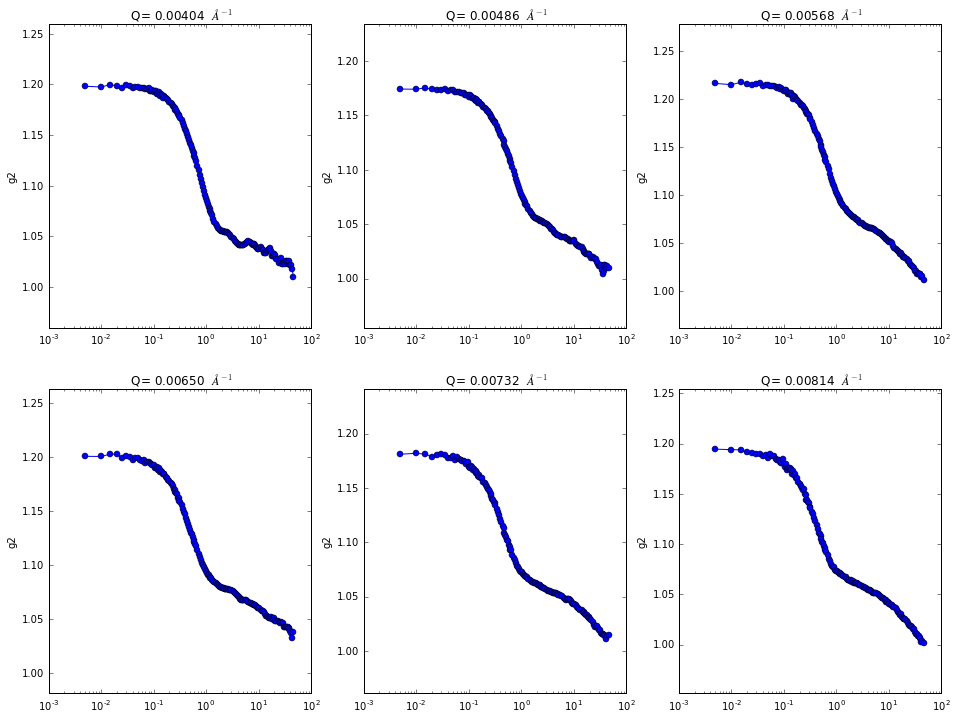

In [56]:
lags = lag_steps*timeperframe

fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    ax.semilogx(lags, g2[:, i], '-o', markersize=6) 
    ax.set_ylim([min(g2[:, i])*.95, max(g2[:, i][1:])*1.05 ])
plt.show()
fig.tight_layout()  